In [1]:
import os
import re
from typing import List, Union, Dict
import time
import requests

from requests.exceptions import ReadTimeout
from requests.exceptions import ReadTimeout, ConnectTimeout
from urllib3.exceptions import NewConnectionError, MaxRetryError
from socket import gaierror

import numpy as np
import pandas as pd
from tqdm import tqdm

from annoy import AnnoyIndex
from sklearn.preprocessing import normalize

from snowflake.connector import SnowflakeConnection
from cdiscount.config import load_secrets
from cdiscount.snowflake import get_snowflake_connection, query_snowflake_to_df, push_to_snowflake, query_snowflake_to_df_batches

import matplotlib.pyplot as plt

In [2]:
from src.azure_openai.config import AzureOpenAIConfig
from src.azure_openai.limiter import Limiter

In [3]:
secrets_file = '/home/jupyter/secrets.yml'
SNOW_SECRETS = load_secrets(filename=secrets_file, key='snowflake')
AZURE_SECRETS = load_secrets(filename=secrets_file, key='azure_openai_embeddings')

In [4]:
query = """
SELECT DISTINCT
    PRODUCT_ID,
    CONCAT(
        'TITRE: ', FP_PRODUCT_NAME, '\n',
        'DESCRIPTION:\n',
        IFF(
            SUBSTRING(PRODUCT_SHORT_DESCRIPTION, 1, 250) = SUBSTRING(PRODUCT_LONG_DESCRIPTION, 1, 250),
            '',
            CONCAT(PRODUCT_SHORT_DESCRIPTION, '\n')
        ),
        PRODUCT_LONG_DESCRIPTION
    ) AS FP_CONTENT
FROM QUALISCORE_LAB.LAB_STAGE_VINCENT_CANAPES_WITH_PROPERTIES;
"""
with get_snowflake_connection(**SNOW_SECRETS) as con:
    products = query_snowflake_to_df(sql_query_or_path=query, con=con)
print(len(products))
print(products.product_id.nunique())
products.head(5)

102877
102877


,product_id,fp_content
0,AUC4803243591214,TITRE: Elégant Canapé droit fixe 2 places - Ca...
1,AUC9419864504530,TITRE: 13262Haut de gamme® Canapé de Relaxatio...
2,AUC3026654499486,"TITRE: MARKET Canapé-lit réglable, Canapé en l..."
3,PWS1686286111693,TITRE: Pwshymi-Canapé-lit avec porte-gobelets ...
4,AUC9189449634296,TITRE: Plus Moderne© Canapé 2 places relax | D...


In [5]:
print(products.fp_content.values[0])

TITRE: Elégant Canapé droit fixe 2 places - Canapé Sofa Divan Contemporain Scandinave Canapé de salon Rouge bordeaux Tissu ☺54985
DESCRIPTION:
⭐⭐⭐⭐⭐Canapé droit fixe 2 places - Canapé Sofa Divan Contemporain Scandinave Canapé de salon Rouge bordeaux Tissu


In [6]:
products.set_index('product_id', inplace=True)

In [7]:
class OpenAIEmbedder:

    def __init__(
        self,
        azure_config: AzureOpenAIConfig,
        model_name: str,
        limiter: Limiter,
    ):
        self.model_name = model_name
        self._limiter = limiter
        self.api_url: str = self._build_api_url(azure_config)
        self.private_key: str = azure_config["private_key"]
        self.expected_embedding_size: int = azure_config["expected_embedding_size"]
        
    @staticmethod
    def _build_api_url(azure_config: Union[AzureOpenAIConfig, Dict]) -> str:
        try:
            url = "/".join(
                [
                    f"https://{azure_config['resource_name']}.openai.azure.com",
                    f"openai/deployments/{azure_config['deployment_name']}",
                    f"{azure_config['model_usage']}"
                ]
            )
            parameters = f"api-version={azure_config['api_version']}"
            complete_url = "?".join([url, parameters])

        except KeyError as e:
            raise Exception(f"Missing parameter in azure configuration : {e}")
            complete_url = ""

        return complete_url   
    
    def embed(self, document: str, retry: int=5, sleep=5) -> (str, int, int): 
        headers = {"Content-Type": "application/json", "api-key": self.private_key}
        data = {
            "input": document,
            "model": self.model_name
        }
        
        try:
            self._limiter.wait_until_available()
            r = requests.post(url=self.api_url, headers=headers, json=data, timeout=30)
        except ReadTimeout:
            r = requests.Response()
            r.status_code = 408
        except (OSError, NewConnectionError, MaxRetryError, gaierror):
            r = requests.Response()
            r.status_code = 500
        finally:
            self._limiter.commit()

        try:
            r = r.json()
            embedding = r['data'][0]['embedding']
            total_tokens = r['usage']['total_tokens']
            return embedding, total_tokens
            # return [d["embedding"] for d in r.json()["data"]]
        except Exception as e:
            if retry:
                # print('Retrying')
                time.sleep(sleep)
                return self.embed(document=document, retry=retry - 1, sleep=sleep)
        return [0.0] * self.expected_embedding_size, -1

In [8]:
model_name = "text-embedding-ada-002"
azure_config = AzureOpenAIConfig(**AZURE_SECRETS)
limiter = Limiter(condition='10000/minute')
embedder = OpenAIEmbedder(azure_config=azure_config, model_name=model_name, limiter=limiter)

In [9]:
embeddings, total_tokens = embedder.embed(document=products.fp_content.to_list()[0:2])
len(embeddings)

1536

In [10]:
schema = 'QUALISCORE_LAB'
table = 'LAB_STAGE_VINCENT_CANAPES_EMBEDDINGS'

In [16]:
# query = f"""
# CREATE TABLE IF NOT EXISTS {schema}.{table} (
#     PRODUCT_ID VARCHAR(500),
#     EMBEDDING ARRAY,
#     TOTAL_TOKEN NUMBER(6, 0)
# )
# """
# print(query)
# # query = f"""DROP TABLE {schema}.{table}"""
# with get_snowflake_connection(**SNOW_SECRETS) as con:
#     res = query_snowflake_to_df(sql_query_or_path=query, con=con)
#     print(res)

In [25]:
n = len(products)
# n = 1000
batch_size = 1000
embeddings = []
total_tokens = []
product_ids = []
for product_id, row in tqdm(products.head(n).iterrows(), total=n):
    embedding, total_token = embedder.embed(document=row['fp_content'])
    product_ids.append(product_id)
    embeddings.append(embedding)
    total_tokens.append(total_token)
    if len(embeddings) == batch_size:
        with get_snowflake_connection(**SNOW_SECRETS) as con:
            res = push_to_snowflake(
                data=pd.DataFrame({
                    'product_id': product_ids,
                    'embedding': embeddings,
                    'total_token': total_tokens
                }),
                schema=schema,
                table=table,
                push_method='insert',
                con=con
            )
            print(res)
        embeddings = []
        total_tokens = []
        product_ids = []

  0%|          | 1/102877 [00:02<78:44:12,  2.76s/it]

{'number of rows inserted': 1}


In [26]:
query = f"""
SELECT COUNT(*), COUNT(DISTINCT PRODUCT_ID)
FROM {schema}.{table};
"""
with get_snowflake_connection(**SNOW_SECRETS) as con:
    res = query_snowflake_to_df(sql_query_or_path=query, con=con)
res

,count(*),count(distinct product_id)
0,102877,102877


# Load a sample of the vector database

In [27]:
query = f"""
SELECT *
FROM {schema}.{table}
SAMPLE (10) SEED(42);
"""
with get_snowflake_connection(**SNOW_SECRETS) as con:
    embedded_products = query_snowflake_to_df(sql_query_or_path=query, con=con)
print(len(embedded_products))
embedded_products.head(3)

10307


,product_id,embedding,total_token
0,DIO7842688800243,"[\n 4.284476400000000e-03,\n -5.277681000000...",163
1,LAM2009847077464,"[\n 5.956652600000000e-03,\n -1.165532700000...",118
2,UNB0086801898572,"[\n -9.640782000000001e-03,\n -5.24768330000...",66


In [28]:
embedded_products['embedding'] = embedded_products.embedding.apply(eval)

In [29]:
embedded_products = embedded_products.merge(right=products, how='inner', on='product_id')

In [30]:
np.all(~embedded_products.embedding.apply(lambda x: np.all(x == 0.0)))

True

(array([1.470e+02, 1.121e+03, 2.935e+03, 5.404e+03, 6.430e+02, 2.700e+01,
        2.000e+01, 7.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00]),
 array([   0.,   50.,  100.,  150.,  200.,  250.,  300.,  350.,  400.,
         450.,  500.,  550.,  600.,  650.,  700.,  750.,  800.,  850.,
         900.,  950., 1000., 1050., 1100., 1150., 1200., 1250., 1300.,
        1350., 1400., 1450., 1500., 1550.]),
 <BarContainer object of 31 artists>)

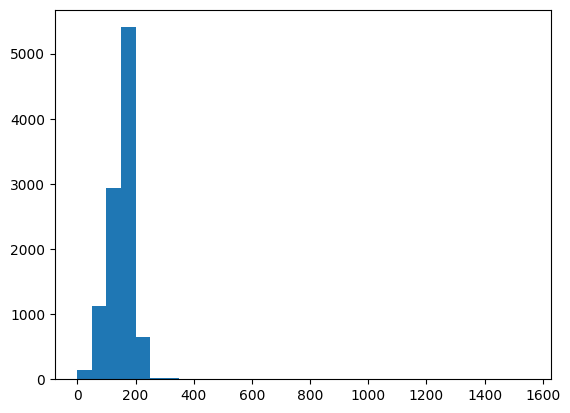

In [31]:
plt.hist(embedded_products.total_token, bins=np.arange(0, 1600, 50))

In [32]:
t = AnnoyIndex(AZURE_SECRETS['expected_embedding_size'], 'dot')
for i, v in enumerate(embedded_products.embedding):
    t.add_item(i, v)
t.build(n_trees=100, n_jobs=-1)
vdb_file = 'embeddings.ann'
t.save(vdb_file)

True

In [33]:
u = AnnoyIndex(AZURE_SECRETS['expected_embedding_size'], 'dot')
u.load(vdb_file)
k = 5
i = 0
neighbors, distances = u.get_nns_by_item(i=i, n=k+1, include_distances=True)
neighbors = neighbors[1:k+1]
distances = np.array(distances[1:k+1])
print(neighbors)
print(distances)
print(normalize(np.expand_dims(distances, axis=0), norm='l1'))

[2096, 7156, 5280, 10262, 7616]
[0.98804462 0.98637015 0.98219055 0.98020816 0.97957128]
[[0.20096975 0.20062916 0.19977902 0.1993758  0.19924626]]


In [34]:
print(embedded_products.fp_content.iloc[i])

TITRE: Canapé-lit Rouge bordeaux Polyester DIOCHE7842688800243
DESCRIPTION:
Couleur: Rouge bordeaux. Matériau: cadre en bois + revêtement en polyester + pieds chromés. Transformation facile en lit. Dimensions du canapé:. Dimensions totales: 168 x 76 x 66 cm (L x l x H). Ajustable en 3 positions. Profondeur d'assise: 41 cm. Largeur d'assise: 168 cm. Hauteur du siège à partir du sol: 28 cm. Dimensions du lit (lorsqu'il est complètement étendu):. Dimensions totales: 168 x 82 x 30 cm (L x l x H)


In [35]:
for i in embedded_products.iloc[neighbors].fp_content:
    print(i)
    print('\n')

TITRE: Canapé-lit Rouge bordeaux Polyester
DESCRIPTION:
●Couleur : Rouge bordeaux●Matériau : cadre en bois + revêtement en polyester + pieds chromés●Transformation facile en lit●Dimensions du canapé :●Dimensions totales : 168 x 76 x 66 cm (L x l x H)●Ajustable en 3 positions●Profondeur d'assise : 41 cm●Largeur d'assise : 168 cm●Hauteur du siège à partir du sol : 28 cm●Dimensions du lit (lorsqu'il est complètement étendu) :●Dimensions totales : 168 x 82 x 30 cm (L x l x


TITRE: Canapé-lit avec accoudoir Rouge bordeaux Polyester
DESCRIPTION:
Couleur : Rouge bordeauxMatériau : cadre en bois + revêtement en polyester + pieds chromésDimensions totales du canapé : 184 x 77,5 x (60,5 / 64 / 66,5) cm (l x P x H)Dimensions du lit (lorsqu'il est entièrement étendu): 168 x 84 x 28 cm (L x l x H)Largeur d'assise : 168 cmProfondeur d'assise : 41 cmHauteur du siège à partir du sol : 28 cmHauteur du dossier : 42 cmLe dossier peut être ajusté en 3 positions


TITRE: Canapé-lit Rouge bordeaux Polyeste

# Load all vector database by batch

In [11]:
query = f"""
SELECT P.*
FROM {schema}.{table} AS P
INNER JOIN (
        SELECT DISTINCT PRODUCT_ID
        FROM SEARCH_DLK.DLK_SCH_REF_PUBLISHED_OFFER
    ) AS O
    ON P.PRODUCT_ID = O.PRODUCT_ID
"""
i = 0
product_ids = []
t = AnnoyIndex(AZURE_SECRETS['expected_embedding_size'], 'dot')
with get_snowflake_connection(**SNOW_SECRETS) as con:
    # En passant le chemin du fichier contenant la requête SQL, et en récupérant un dataframe pandas
    for embeddings in query_snowflake_to_df_batches(sql_query_or_path=query, con=con):
        product_ids += embeddings.product_id.to_list()
        embeddings = embeddings.embedding.apply(eval)
        for embedding in embeddings:
            t.add_item(i, embedding)
            i += 1
            print(f"{i:6d}/{len(products)}", end='\r')
t.build(n_trees=100, n_jobs=-1)
vdb_file = 'data/20231025_stage_vincent_openai_embeddings.ann'
t.save(vdb_file)

True

In [12]:
embedded_products = (
    pd.DataFrame({'product_id': product_ids})
    .merge(right=products, how='left', on='product_id')
)
print(len(embedded_products))
embedded_products.head(3)

78835


,product_id,fp_content
0,ATY7049254831551,TITRE: Atyhao Canapé-lit avec accoudoirs jaune...
1,AKO7370392809059,TITRE: Canapé-lit avec porte-gobelets gris fon...
2,OMA1695359450253,TITRE: Omabeta housse de canapé extensible Hou...


In [25]:
u = AnnoyIndex(AZURE_SECRETS['expected_embedding_size'], 'dot')
u.load(vdb_file)
k = 5
i = 4
neighbors, distances = u.get_nns_by_item(i=i, n=k+1, include_distances=True)
neighbors = neighbors[1:k+1]
distances = np.array(distances[1:k+1])
print(neighbors)
print(distances)
print(normalize(np.expand_dims(distances, axis=0), norm='l1'))

[9694, 20724, 72424, 29866, 51138]
[0.99955821 0.99466342 0.99462736 0.99347198 0.9915266 ]
[[0.20096278 0.19997867 0.19997142 0.19973913 0.19934801]]


In [26]:
print(embedded_products.fp_content.iloc[i])

TITRE: Housses de Canapé - Protection du Sofa - pour canapé d'angle en forme de L 3+2 places - Café LAN9458
DESCRIPTION:
Fabriqué en polyester de haute qualité, doux, confortable à asseoir et durable Une couleur simple et élégante donne à vos meubles un tout nouveau look, idéal pour un canapé à la maison


In [27]:
for i in embedded_products.iloc[neighbors].fp_content:
    print(i)
    print('\n')

TITRE: Housses de Canapé - Protection du Sofa - pour canapé d'angle en forme de L 3+2 places - Café LAN9462
DESCRIPTION:
Fabriqué en polyester de haute qualité, doux, confortable à asseoir et durable Une couleur simple et élégante donne à vos meubles un tout nouveau look, idéal pour un canapé à la maison


TITRE: Housses de Canapé - Protection du Sofa - pour canapé d'angle en forme de L 3+2 places - Café LAN9460
DESCRIPTION:
Une couleur simple et élégante donne à vos meubles un tout nouveau look, idéal pour un canapé à la maison Fabriqué en polyester de haute qualité, doux, confortable à asseoir et durable


TITRE: Housses de Canapé - Protection du Sofa - pour canapé d'angle en forme de L 3+2 places - Café CEN-36
DESCRIPTION:
Fabriqué en polyester de haute qualité, doux, confortable à asseoir et durable Une couleur simple et élégante donne à vos meubles un tout nouveau look, idéal pour un canapé à la maison


TITRE: Housses de Canapé - Protection du Sofa - pour canapé d'angle en forme 

In [ ]:
# 0.0001 for 1,000 tokens

In [17]:
query = f"""
SELECT PRODUCT_ID, TOTAL_TOKEN
FROM {schema}.{table};
"""
with get_snowflake_connection(**SNOW_SECRETS) as con:
    total_tokens = query_snowflake_to_df(sql_query_or_path=query, con=con)
total_tokens.head(3)

,product_id,total_token
0,VBE1684907193839,115
1,MIC5903614335436,184
2,VEN3666471045550,145


In [20]:
0.0001 * total_tokens.total_token.sum() / 1000

1.5738151

In [21]:
100_000_000 * 0.0001 * total_tokens.total_token.sum() / 1000 / 1028_77

1529.8026769831936

In [31]:
u = AnnoyIndex(AZURE_SECRETS['expected_embedding_size'], 'dot')
u.load(vdb_file)

True

In [45]:
def get_neighbors(u, i, k):
    neighbors, distances = u.get_nns_by_item(i=i, n=k+1, include_distances=True)
    return pd.DataFrame({
        'id': i,
        'rank': [j for j in range(1, k+1)],
        'neighbor_id': neighbors[1:k+1],
        'distance': distances[1:k+1]
    })

In [42]:
u.get_n_items()

78835

In [91]:
all_neighbors = []
for i in tqdm(range(0, u.get_n_items())):
    all_neighbors.append(get_neighbors(u=u, i=i, k=50))
all_neighbors = pd.concat(all_neighbors)

100%|██████████| 78835/78835 [04:07<00:00, 318.63it/s]


In [92]:
all_neighbors

,id,rank,neighbor_id,distance
0,0,1,27290,0.999813
1,0,2,13917,0.999773
2,0,3,13660,0.999748
3,0,4,28178,0.999021
4,0,5,768,0.997327
...,...,...,...,...
45,78834,46,39072,0.957576
46,78834,47,20628,0.957116
47,78834,48,68253,0.957007
48,78834,49,6566,0.956644


Text(0, 0.5, '# of neighboring product pairs')

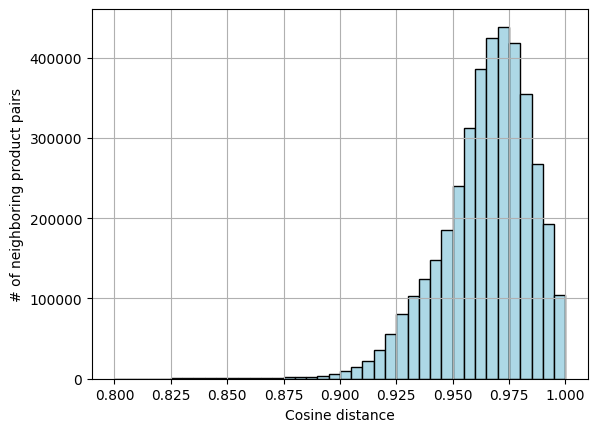

In [124]:
step = 0.005
bins = np.arange(0.8, 1.0 + 1.0E-8, step)
ax = all_neighbors.distance.hist(bins=bins, edgecolor='k', color='lightblue')
ax.set_xlabel('Cosine distance')
ax.set_ylabel('# of neighboring product pairs')

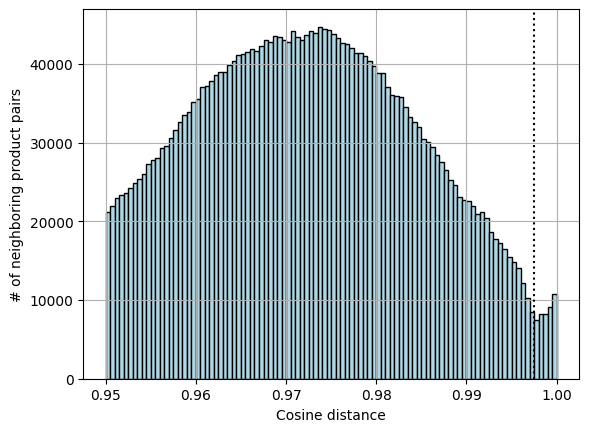

In [133]:
step = 0.0005
bins = np.arange(0.95, 1.0 + 1.0E-8, step)
ax = all_neighbors.distance.hist(bins=bins, edgecolor='k', color='lightblue')
ax.set_xlabel('Cosine distance')
ax.set_ylabel('# of neighboring product pairs')
ax.axvline(0.9975, ls=':', color='k')

In [121]:
start = 0.99
pair = all_neighbors.loc[lambda x: x.distance.between(left=start, right=start+step)].sample(n=1)
print(pair)
print()
print(embedded_products.iloc[pair['id'].item()].fp_content)
print()
print(embedded_products.iloc[pair['neighbor_id'].item()].fp_content)

       id  rank  neighbor_id  distance
30  14875    31        34861  0.993515

TITRE: XJYDNCG Housse de canapé extensible universelle sans accoudoir extensible 190 *160 cm-8541RGV
DESCRIPTION:
Matière: 95% polyester + 5% élasthanneFait de tissus confortables, doux au toucher.
Peut être détaché pour nettoyer à tout moment, propre et hygiénique. 
Dimensions: Convient aux canapés-lits sans accoudoirs d'une longueur de 160 à 190 cm, d'une prof

TITRE: XJYDNCG housse de canapé extensible universelle sans accoudoir extensible 190*160cm-RE5G1
DESCRIPTION:
Matière: 95% polyester + 5% élasthanneFait de tissus confortables, doux au toucher.
Peut être détaché pour nettoyer à tout moment, propre et hygiénique. 
Dimensions: Convient aux canapés-lits sans accoudoirs d'une longueur de 160 à 190 cm, d'une prof


In [135]:
pair = all_neighbors.loc[lambda x: x.distance.gt(0.9975)].sample(n=1)
print(pair)
print()
print(embedded_products.iloc[pair['id'].item()].product_id)
print(embedded_products.iloc[pair['id'].item()].fp_content)
print()
print(embedded_products.iloc[pair['neighbor_id'].item()].product_id)
print(embedded_products.iloc[pair['neighbor_id'].item()].fp_content)

      id  rank  neighbor_id  distance
0  24456     1        34856  0.999812

TBE1695354212021
TITRE: HOP-Canapé-lit à 2 places Noir Velours-HOP337385
DESCRIPTION:
Produit:HOP337385. Couleur: Noir. Matériau: velours (100 % polyester), bois, plastique. Matériau de remplissage: Mousse. Facilement convertible en lit. Dimensions du canapé:. Dimensions totales: 220 x 84,5 x 69 cm (L x l x H). Profondeur du siège: 50 cm. Épaisseur du siège: 15 cm. Hauteur du siège à partir du sol: 32 cm. Hauteur du dossier (en position haute): 69 cm. Hauteur du dossier (à mi-hauteur): 56 cm. Épaisseu

TBE1695353788438
TITRE: HOP-Canapé-lit à 2 places Noir Velours-HOP337656
DESCRIPTION:
Produit:HOP337656. Couleur: Noir. Matériau: velours (100 % polyester), bois, plastique. Matériau de remplissage: Mousse. Facilement convertible en lit. Dimensions du canapé:. Dimensions totales: 220 x 84,5 x 69 cm (L x l x H). Profondeur du siège: 50 cm. Épaisseur du siège: 15 cm. Hauteur du siège à partir du sol: 32 cm. Hauteu